# SPARK-ONE-OFF DASHBOARD

In [1]:
#get aws keys
import csv
with open('private/accessKeys.csv') as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    for line in readCSV:
        access_key = line[0]
        secret_key = line[1]

In [2]:
#use pyathenajdbc to query an athena table
from pyathenajdbc import connect
import pandas as pd
import numpy as np
connection = connect(access_key=access_key, secret_key=secret_key, s3_staging_dir='s3://spark-one-off/pyathena/',
    region_name='us-west-2')

In [3]:
#read train table into dataframe...is slow, likely due to pyathenajdbc
query = 'select * from oneoff.train'
train = pd.read_sql(query, connection)
#print train.dtypes
train.head(5)

,id,ran_num,class,xscore,oscore,bscore,x0,y0,x,y
0,0,0.468592,B,0.0,0.0,1.0,2.617087,-5.041037,2.369399,-5.210723
1,1,0.202284,B,0.0,0.0,1.0,-2.882486,-6.157884,-3.827595,-6.340319
2,2,0.759946,B,0.0,0.0,1.0,6.460290,1.352827,6.797249,1.032348
3,3,0.210276,B,0.0,0.0,1.0,0.627236,-6.578981,1.171388,-5.657434
4,4,0.981474,B,0.0,0.0,1.0,-6.275526,3.397966,-6.201447,3.370451


### 5 records in the training data (above), plus some stats (below)

In [4]:
#get indices of X, O and B classes
print 'number of records in train = ', len(train)
idx_x = train['class'] == 'X'
idx_o = train['class'] == 'O'
idx_b = train['class'] == 'B'
print 'X fraction = ', idx_x.sum()*1.0/len(idx_x)
print 'O fraction = ', idx_o.sum()*1.0/len(idx_o)
print 'B fraction = ', idx_b.sum()*1.0/len(idx_b)
print 'B/O ratio = ', idx_b.sum()*1.0/idx_o.sum()

number of records in train =  15000
X fraction =  0.1358
O fraction =  0.127133333333
B fraction =  0.737066666667
B/O ratio =  5.79758783429


In [5]:
#prep plots
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.2, font='DejaVu Sans')

## Colors indicate class boundaries

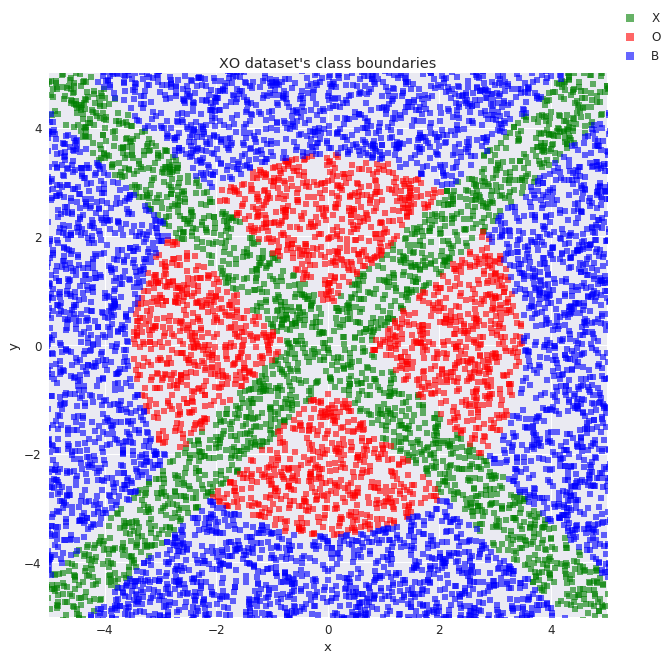

In [6]:
#scatterplot of jitterless (x0,y0) data, to show actual decision boundaries
f, ax = plt.subplots(figsize=(10, 10))
df = train
clr = 'green'
idx = idx_x
xp = df['x0'][idx]
yp = df['y0'][idx]
p = sns.regplot(xp, yp, ax=ax, fit_reg=False, scatter_kws={'alpha':0.6, 's': 26}, color=clr, marker='s', label='X')
clr = 'red'
idx = idx_o
xp = df['x0'][idx]
yp = df['y0'][idx]
sns.regplot(xp, yp, ax=p, fit_reg=False, scatter_kws={'alpha':0.6, 's': 26}, color=clr, marker='s', label='O')
clr = 'blue'
idx = idx_b
xp = df['x0'][idx]
yp = df['y0'][idx]
sns.regplot(xp, yp, ax=p, fit_reg=False, scatter_kws={'alpha':0.6, 's': 26}, color=clr, marker='s', label='B')
p.set_title("XO dataset's class boundaries")
p.set_xlabel('x')
p.set_ylabel('y')
p.set_xlim(-5.0, 5.0)
p.set_ylim(-5.0, 5.0)
scat_plot = p.legend(bbox_to_anchor=(1.0, 1.0), markerscale=1.5)

### each dot has x,y coordinates whose location determines whether a dot is a member of the green X class, red O class, or blue B background class

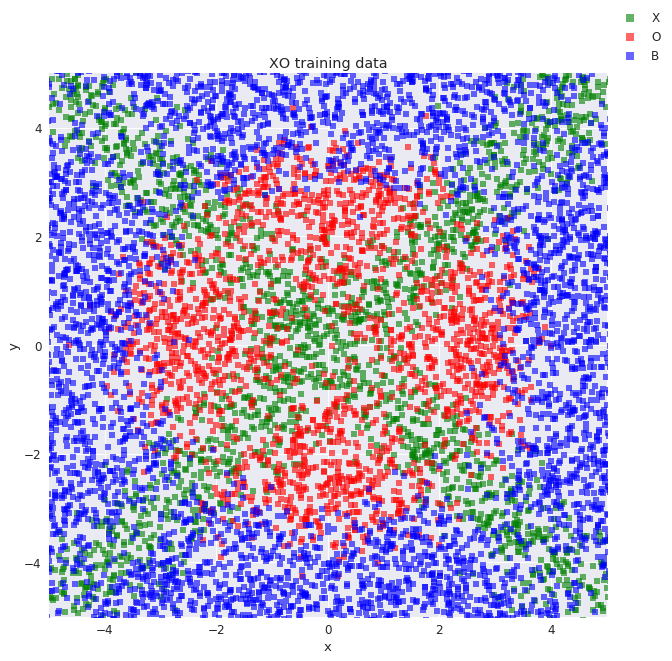

In [7]:
#scatterplot of training (x,y) data
f, ax = plt.subplots(figsize=(10, 10))
df = train
clr = 'green'
idx = idx_x
xp = df['x'][idx]
yp = df['y'][idx]
p = sns.regplot(xp, yp, ax=ax, fit_reg=False, scatter_kws={'alpha':0.6, 's': 26}, color=clr, marker='s', label='X')
clr = 'red'
idx = idx_o
xp = df['x'][idx]
yp = df['y'][idx]
sns.regplot(xp, yp, ax=p, fit_reg=False, scatter_kws={'alpha':0.6, 's': 26}, color=clr, marker='s', label='O')
clr = 'blue'
idx = idx_b
xp = df['x'][idx]
yp = df['y'][idx]
sns.regplot(xp, yp, ax=p, fit_reg=False, scatter_kws={'alpha':0.6, 's': 26}, color=clr, marker='s', label='B')
p.set_title('XO training data')
p.set_xlabel('x')
p.set_ylabel('y')
p.set_xlim(-5.0, 5.0)
p.set_ylim(-5.0, 5.0)
scat_plot = p.legend(bbox_to_anchor=(1.0, 1.0), markerscale=1.5)

### after all dots are assigned to the X O or B classes, their x,y coordinates are then given random kicks. This causes adjacent classes to bleed into each other, and makes the XOB class boundaries rather fuzzy. Adding noise to this data also make the training of an MLP classifier more challenging

In [8]:
#get the number of different hidden layers
pd.read_sql('select distinct(N_hidden) as N_hidden from oneoff.grid order by N_hidden', connection)

,N_hidden
0,5
1,7
2,10
3,30
4,50
5,75
6,100
7,200
8,400
9,600


### 10 different MLP models are trained on the XO dataset, and the above chart shows the number of neurons used in each model's hidden layer. It is expected that models with low N_hidden will tend to suffer underfitting, while too-high values can result in overfitting 

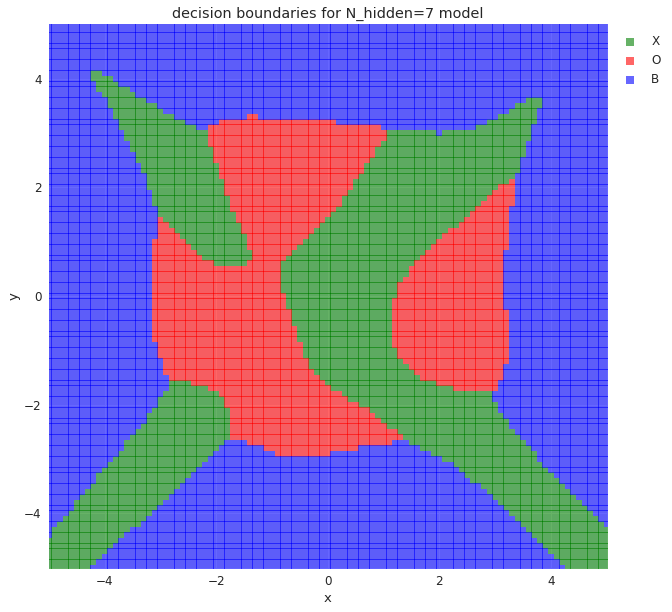

In [9]:
#decision surface for MLP model having 7 neurons in hidden layer
N_hidden = '7'
query = 'select * from oneoff.grid where (N_hidden=' + N_hidden + ')'
grid = pd.read_sql(query, connection)
#print grid.dtypes
#print 'number of records in grid = ', len(grid)
#print grid.head(5)
f, ax = plt.subplots(figsize=(10, 10))
df = grid
clr = 'green'
idx = df['class_pred'] == 'X'
xp = df['x'][idx]
yp = df['y'][idx]
p = sns.regplot(xp, yp, ax=ax, fit_reg=False, scatter_kws={'alpha':0.6, 's': 26}, color=clr, marker='s', label='X')
clr = 'red'
idx = df['class_pred'] == 'O'
xp = df['x'][idx]
yp = df['y'][idx]
sns.regplot(xp, yp, ax=p, fit_reg=False, scatter_kws={'alpha':0.6, 's': 26}, color=clr, marker='s', label='O')
clr = 'blue'
idx = df['class_pred'] == 'B'
xp = df['x'][idx]
yp = df['y'][idx]
sns.regplot(xp, yp, ax=p, fit_reg=False, scatter_kws={'alpha':0.6, 's': 26}, color=clr, marker='s', label='B')
p.set_title('decision boundaries for N_hidden=' + N_hidden +' model')
p.set_xlabel('x')
p.set_ylabel('y')
p.set_xlim(-5.0, 5.0)
p.set_ylim(-5.0, 5.0)
scat_plot = p.legend(bbox_to_anchor=(1.0, 1.0), markerscale=1.5)

### the N_hidden=7 model (above) exhibits underfitting, and is not sophisticated enough to represent the dataset's actual structure

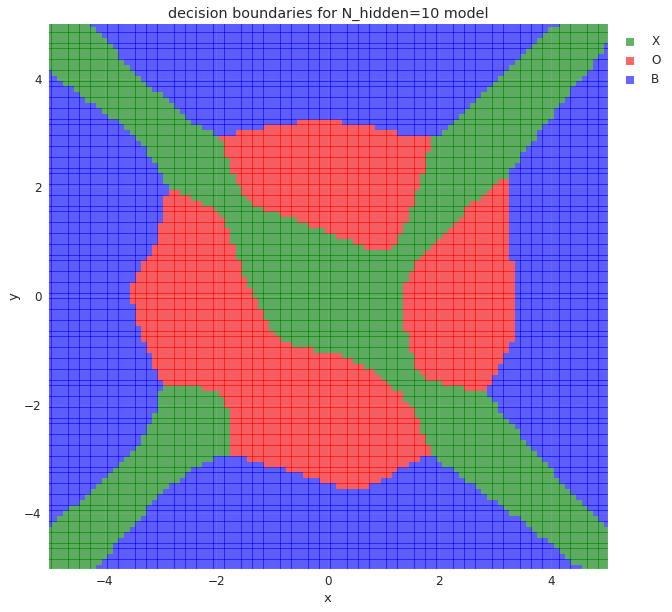

In [10]:
#decision surface for MLP model having 10 neurons in hidden layer
N_hidden = '10'
query = 'select * from oneoff.grid where (N_hidden=' + N_hidden + ')'
grid = pd.read_sql(query, connection)
#print grid.dtypes
#print 'number of records in grid = ', len(grid)
#print grid.head(5)
f, ax = plt.subplots(figsize=(10, 10))
df = grid
clr = 'green'
idx = df['class_pred'] == 'X'
xp = df['x'][idx]
yp = df['y'][idx]
p = sns.regplot(xp, yp, ax=ax, fit_reg=False, scatter_kws={'alpha':0.6, 's': 26}, color=clr, marker='s', label='X')
clr = 'red'
idx = df['class_pred'] == 'O'
xp = df['x'][idx]
yp = df['y'][idx]
sns.regplot(xp, yp, ax=p, fit_reg=False, scatter_kws={'alpha':0.6, 's': 26}, color=clr, marker='s', label='O')
clr = 'blue'
idx = df['class_pred'] == 'B'
xp = df['x'][idx]
yp = df['y'][idx]
sns.regplot(xp, yp, ax=p, fit_reg=False, scatter_kws={'alpha':0.6, 's': 26}, color=clr, marker='s', label='B')
p.set_title('decision boundaries for N_hidden=' + N_hidden +' model')
p.set_xlabel('x')
p.set_ylabel('y')
p.set_xlim(-5.0, 5.0)
p.set_ylim(-5.0, 5.0)
scat_plot = p.legend(bbox_to_anchor=(1.0, 1.0), markerscale=1.5)

### the N_hidden=10 model also shows underfitting

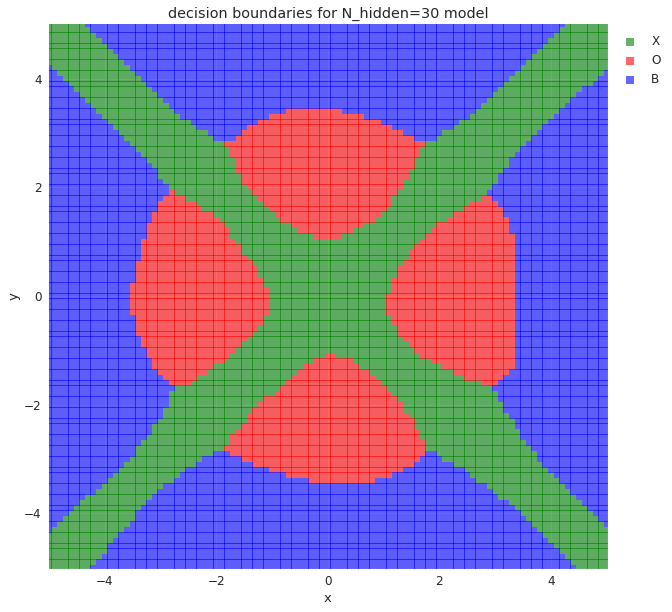

In [11]:
#decision surface for MLP model having 30 neurons in hidden layer
N_hidden = '30'
query = 'select * from oneoff.grid where (N_hidden=' + N_hidden + ')'
grid = pd.read_sql(query, connection)
#print grid.dtypes
#print 'number of records in grid = ', len(grid)
#print grid.head(5)
f, ax = plt.subplots(figsize=(10, 10))
df = grid
clr = 'green'
idx = df['class_pred'] == 'X'
xp = df['x'][idx]
yp = df['y'][idx]
p = sns.regplot(xp, yp, ax=ax, fit_reg=False, scatter_kws={'alpha':0.6, 's': 26}, color=clr, marker='s', label='X')
clr = 'red'
idx = df['class_pred'] == 'O'
xp = df['x'][idx]
yp = df['y'][idx]
sns.regplot(xp, yp, ax=p, fit_reg=False, scatter_kws={'alpha':0.6, 's': 26}, color=clr, marker='s', label='O')
clr = 'blue'
idx = df['class_pred'] == 'B'
xp = df['x'][idx]
yp = df['y'][idx]
sns.regplot(xp, yp, ax=p, fit_reg=False, scatter_kws={'alpha':0.6, 's': 26}, color=clr, marker='s', label='B')
p.set_title('decision boundaries for N_hidden=' + N_hidden +' model')
p.set_xlabel('x')
p.set_ylabel('y')
p.set_xlim(-5.0, 5.0)
p.set_ylim(-5.0, 5.0)
scat_plot = p.legend(bbox_to_anchor=(1.0, 1.0), markerscale=1.5)

### while the N_hidden=30 model comes closest to predicting the dataset's actual decision boundaries 

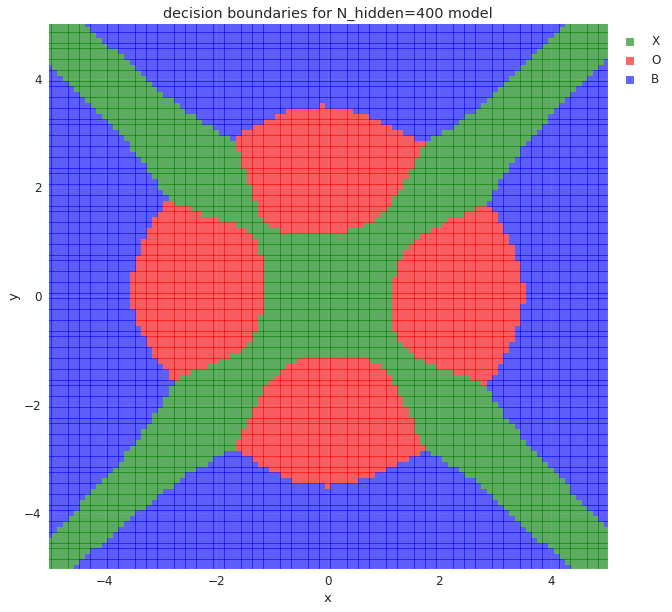

In [12]:
#decision surface for MLP model having 400 neurons in hidden layer
N_hidden = '400'
query = 'select * from oneoff.grid where (N_hidden=' + N_hidden + ')'
grid = pd.read_sql(query, connection)
#print grid.dtypes
#print 'number of records in grid = ', len(grid)
#print grid.head(5)
f, ax = plt.subplots(figsize=(10, 10))
df = grid
clr = 'green'
idx = df['class_pred'] == 'X'
xp = df['x'][idx]
yp = df['y'][idx]
p = sns.regplot(xp, yp, ax=ax, fit_reg=False, scatter_kws={'alpha':0.6, 's': 26}, color=clr, marker='s', label='X')
clr = 'red'
idx = df['class_pred'] == 'O'
xp = df['x'][idx]
yp = df['y'][idx]
sns.regplot(xp, yp, ax=p, fit_reg=False, scatter_kws={'alpha':0.6, 's': 26}, color=clr, marker='s', label='O')
clr = 'blue'
idx = df['class_pred'] == 'B'
xp = df['x'][idx]
yp = df['y'][idx]
sns.regplot(xp, yp, ax=p, fit_reg=False, scatter_kws={'alpha':0.6, 's': 26}, color=clr, marker='s', label='B')
p.set_title('decision boundaries for N_hidden=' + N_hidden +' model')
p.set_xlabel('x')
p.set_ylabel('y')
p.set_xlim(-5.0, 5.0)
p.set_ylim(-5.0, 5.0)
scat_plot = p.legend(bbox_to_anchor=(1.0, 1.0), markerscale=1.5)

### however neural nets having N_hidden=400+ neurons in their hidden layer tends to exhibit overfitting

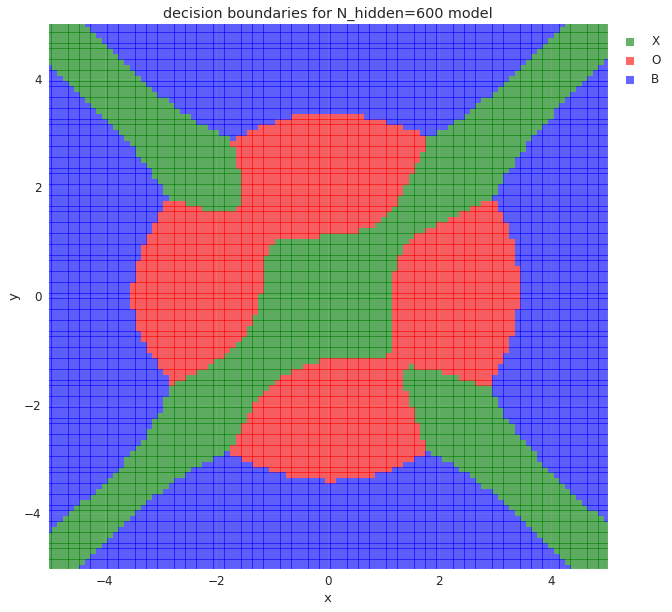

In [13]:
#decision surface for MLP model having 600 neurons in hidden layer
N_hidden = '600'
query = 'select * from oneoff.grid where (N_hidden=' + N_hidden + ')'
grid = pd.read_sql(query, connection)
#print grid.dtypes
#print 'number of records in grid = ', len(grid)
#print grid.head(5)
f, ax = plt.subplots(figsize=(10, 10))
df = grid
clr = 'green'
idx = df['class_pred'] == 'X'
xp = df['x'][idx]
yp = df['y'][idx]
p = sns.regplot(xp, yp, ax=ax, fit_reg=False, scatter_kws={'alpha':0.6, 's': 26}, color=clr, marker='s', label='X')
clr = 'red'
idx = df['class_pred'] == 'O'
xp = df['x'][idx]
yp = df['y'][idx]
sns.regplot(xp, yp, ax=p, fit_reg=False, scatter_kws={'alpha':0.6, 's': 26}, color=clr, marker='s', label='O')
clr = 'blue'
idx = df['class_pred'] == 'B'
xp = df['x'][idx]
yp = df['y'][idx]
sns.regplot(xp, yp, ax=p, fit_reg=False, scatter_kws={'alpha':0.6, 's': 26}, color=clr, marker='s', label='B')
p.set_title('decision boundaries for N_hidden=' + N_hidden +' model')
p.set_xlabel('x')
p.set_ylabel('y')
p.set_xlim(-5.0, 5.0)
p.set_ylim(-5.0, 5.0)
scat_plot = p.legend(bbox_to_anchor=(1.0, 1.0), markerscale=1.5)